## The Code Example

Following is the code example on how we can implement an anomaly detection system for NYC Taxi. 

The example includes three sections:
1. **Data Preparing**: We use pandas to read the data from NYC.org and transform them into the input for our data;
2. **Modelling with PySAD**: We use the PySAD package to build our Streaming Anomaly Detection (SAD) model for scoring the data points as we would do in actual production settings.
3. **Visualizing the Anomaly**: We picked a data point with high anomaly score (deemed as anomaly by SAD), and visualize the half-hour demand difference from normal expectations, so as to demonstrate the anomaly and provide insights on how to increase profits in face of this anomaly.

Each part of this erxample can be run individually with prepared data in the repository.

### 1. Data Preparing
The data we use is an open dataset provided by NYC.org.

In this section, we will start from acquiring raw data from NYC.org and try to summarize it down to the level where our model takes. This step resembles the data streaming and transforming process in actual implementation, but the data summarized each time then would be in much smaller size and therefore much quicker.

If you would like to run this notebook yourself, it is recommended that you skip this section and use the prepared dataset instead, since it would require you to download 7GB data from the website and will cost you a lot of time.

In [25]:
import pandas as pd

In [312]:
link = 'https://nyc-tlc.s3.amazonaws.com/trip+data/fhvhv_tripdata_{}.csv'
# we will be simulating the anomaly detection process in the time frame from 2019-11 to 2020-06
months = ['2019-11',
          '2019-12',
          '2020-01',
          '2020-02',
          '2020-03',
          '2020-04',
          '2020-05',
          '2020-06']

In [313]:
# WARINING: again, if you are trying to run this notebook, it's recommended that you skip this
# and jump to the next section, since this chunk will download 7GB data and cost you a lot of time.
time_series = pd.DataFrame()

for month in [months[0]]:
    tmp = pd.read_csv(link.format(month), usecols=['pickup_datetime', 'PULocationID'])
    tmp['pickup_datetime'] = pd.to_datetime(tmp['pickup_datetime'])
    # this loop is to reduce memory requirement
    # this step also requires a lot of memory space
    dates = tmp['pickup_datetime'].dt.date.unique()
    for date in dates:
        print(date)
        df = tmp[tmp['pickup_datetime'].dt.date==date]
        df = pd.concat([df, pd.get_dummies(df['PULocationID'], prefix='zone')], axis=1)
        df = df.drop('PULocationID',axis=1).set_index('pickup_datetime')
        df = df.resample('30min').sum()
        time_series = pd.concat([time_series, df])

2019-11-01
2019-11-02
2019-11-03
2019-11-04
2019-11-05
2019-11-06
2019-11-07
2019-11-08
2019-11-09
2019-11-10
2019-11-11
2019-11-12
2019-11-13
2019-11-14
2019-11-15
2019-11-16
2019-11-17
2019-11-18
2019-11-19
2019-11-20
2019-11-21
2019-11-22
2019-11-23
2019-11-24
2019-11-25
2019-11-26
2019-11-27
2019-11-28
2019-11-29
2019-11-30


In [40]:
time_series.to_csv('time_series_by_zone.csv')

### 2. Modelling with PySAD
This section will utilize the XStream model implemented by PySAD.

In [160]:
import pandas as pd
from pysad.models import xStream
from pysad.transform.probability_calibration import ConformalProbabilityCalibrator

In [315]:
time_series = pd.read_csv('time_series_by_zone.csv')
time_series['pickup_datetime'] = pd.to_datetime(time_series['pickup_datetime'])
time_series = time_series.set_index('pickup_datetime')

Since the taxi order through out the day following a similar pattern (same for weekly, monthly, yearly, etc.) The Seasonality in the fluctuation should be accounted (potentially use packages like prophet). 

In this case, however, we will mitigate this by compare data points with same time in day, for the sake of simplicity. You can always add other models to get an expected time series and use the difference in actual time series as the input.

In [317]:
time_series['hour'] = time_series.index.hour
time_series['minute'] = time_series.index.minute
time_series['partition'] = time_series['hour'] * 2 + time_series['minute'] / 30 + 1

dataset = []

for i in range(1, 49):
    tmp = time_series[time_series['partition']==i].drop(['hour', 'minute', 'partition'], axis=1)
    dataset.append(tmp)

Training the model. This will take a long time since we are going through 1 million+ data points one by one, fitting and scoring in order.

In real-world implementation, it will only fit and score once for each data point that comes in, providing real-time feedback on anomaly.

In [318]:
for data in dataset:
    # we estimate that 30 days is a good estimate for building an expectation on demands
    model = xStream(window_size = 30)
    calibrator = ConformalProbabilityCalibrator(windowed=True, window_size=30)
    scores = model.fit_score(data.values)
    scores = calibrator.fit_transform(scores)
    data['score'] = scores

In [319]:
res = pd.DataFrame()

for data in dataset:
    res = pd.concat([res,data])

In [320]:
res = res.sort_index()
res.head()

,zone_1,zone_2,zone_3,zone_4,zone_5,zone_6,zone_7,zone_8,zone_9,zone_10,...,zone_259,zone_260,zone_261,zone_262,zone_263,zone_265,zone_110,zone_105,zone_199,score
pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2019-11-01 00:00:00,0.0,0.0,23.0,96.0,4.0,16.0,228.0,0.0,10.0,27.0,...,42.0,61.0,71.0,27.0,105.0,1.0,NaN,NaN,NaN,0.0
2019-11-01 00:30:00,0.0,0.0,9.0,118.0,1.0,6.0,207.0,0.0,20.0,18.0,...,31.0,39.0,51.0,18.0,60.0,1.0,NaN,NaN,NaN,0.0
2019-11-01 01:00:00,2.0,0.0,6.0,97.0,1.0,4.0,162.0,0.0,9.0,15.0,...,40.0,39.0,32.0,20.0,74.0,1.0,NaN,NaN,NaN,0.0
2019-11-01 01:30:00,1.0,0.0,14.0,97.0,1.0,4.0,172.0,0.0,13.0,10.0,...,30.0,45.0,41.0,14.0,43.0,2.0,NaN,NaN,NaN,0.0
2019-11-01 02:00:00,2.0,0.0,10.0,66.0,1.0,2.0,121.0,1.0,32.0,13.0,...,17.0,48.0,19.0,10.0,41.0,0.0,NaN,NaN,NaN,0.0


In [282]:
res.to_csv('res_by_half_hour_30.csv')

### Visualizing the Anomaly
In this section, we demonstrate an anomaly by visualize a demand change map at the time point. This is also where the insights come from. Managers and drivers of the company can use these insights in changing demands to adjust their normal strategies in chase of higher profits.

In [333]:
import geopandas as gp
import pandas as pd
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt

In [343]:
df = pd.read_csv('res_by_hour_30.csv')
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df = pd.melt(df, 'pickup_datetime', df.columns[2:-2], 'LocationID', 'trips').fillna(0)

# The time point 2020-6-27 12:00:00 score high in anomaly.
# We try to visualize demands at that point compared to expected demands from previous 30 days 
time = datetime(2020,6,27,12,0)

now = df[df['pickup_datetime']==time]
earlier = df[(df['pickup_datetime'] >= time+timedelta(days=-30)) & 
             (df['pickup_datetime'] >= time+timedelta(days=-1))].groupby('LocationID')['trips'].mean()
earlier_std = df[(df['pickup_datetime'] >= time+timedelta(days=-30)) & 
             (df['pickup_datetime'] >= time+timedelta(days=-1))].groupby('LocationID')['trips'].std()
earlier.name = 'earlier'
earlier_std.name = 'earlier_std'
now = now.join(earlier, on = 'LocationID')
now = now.join(earlier_std, on = 'LocationID')
now['diff'] = now['trips'] - now['earlier']
# here we use z-score to describe the deviation from expectation
now['zscore'] = now['diff']/now['earlier_std']
# If the zone had low order counts in the previous, 
# it's subject to high volatility and is not really of interest
now.loc[now['earlier']<=10, 'zscore'] = 0

In [344]:
# import and merge the shape file of the zones
m = gp.read_file('taxi_zones/taxi_zones.shp')
now['LocationID'] = now['LocationID'].apply(lambda x: int(x.split('_')[1]))
now = m.merge(now, on='LocationID')

(905464.7390389859, 1075092.878374982, 112485.76061678902, 280480.4146430247)

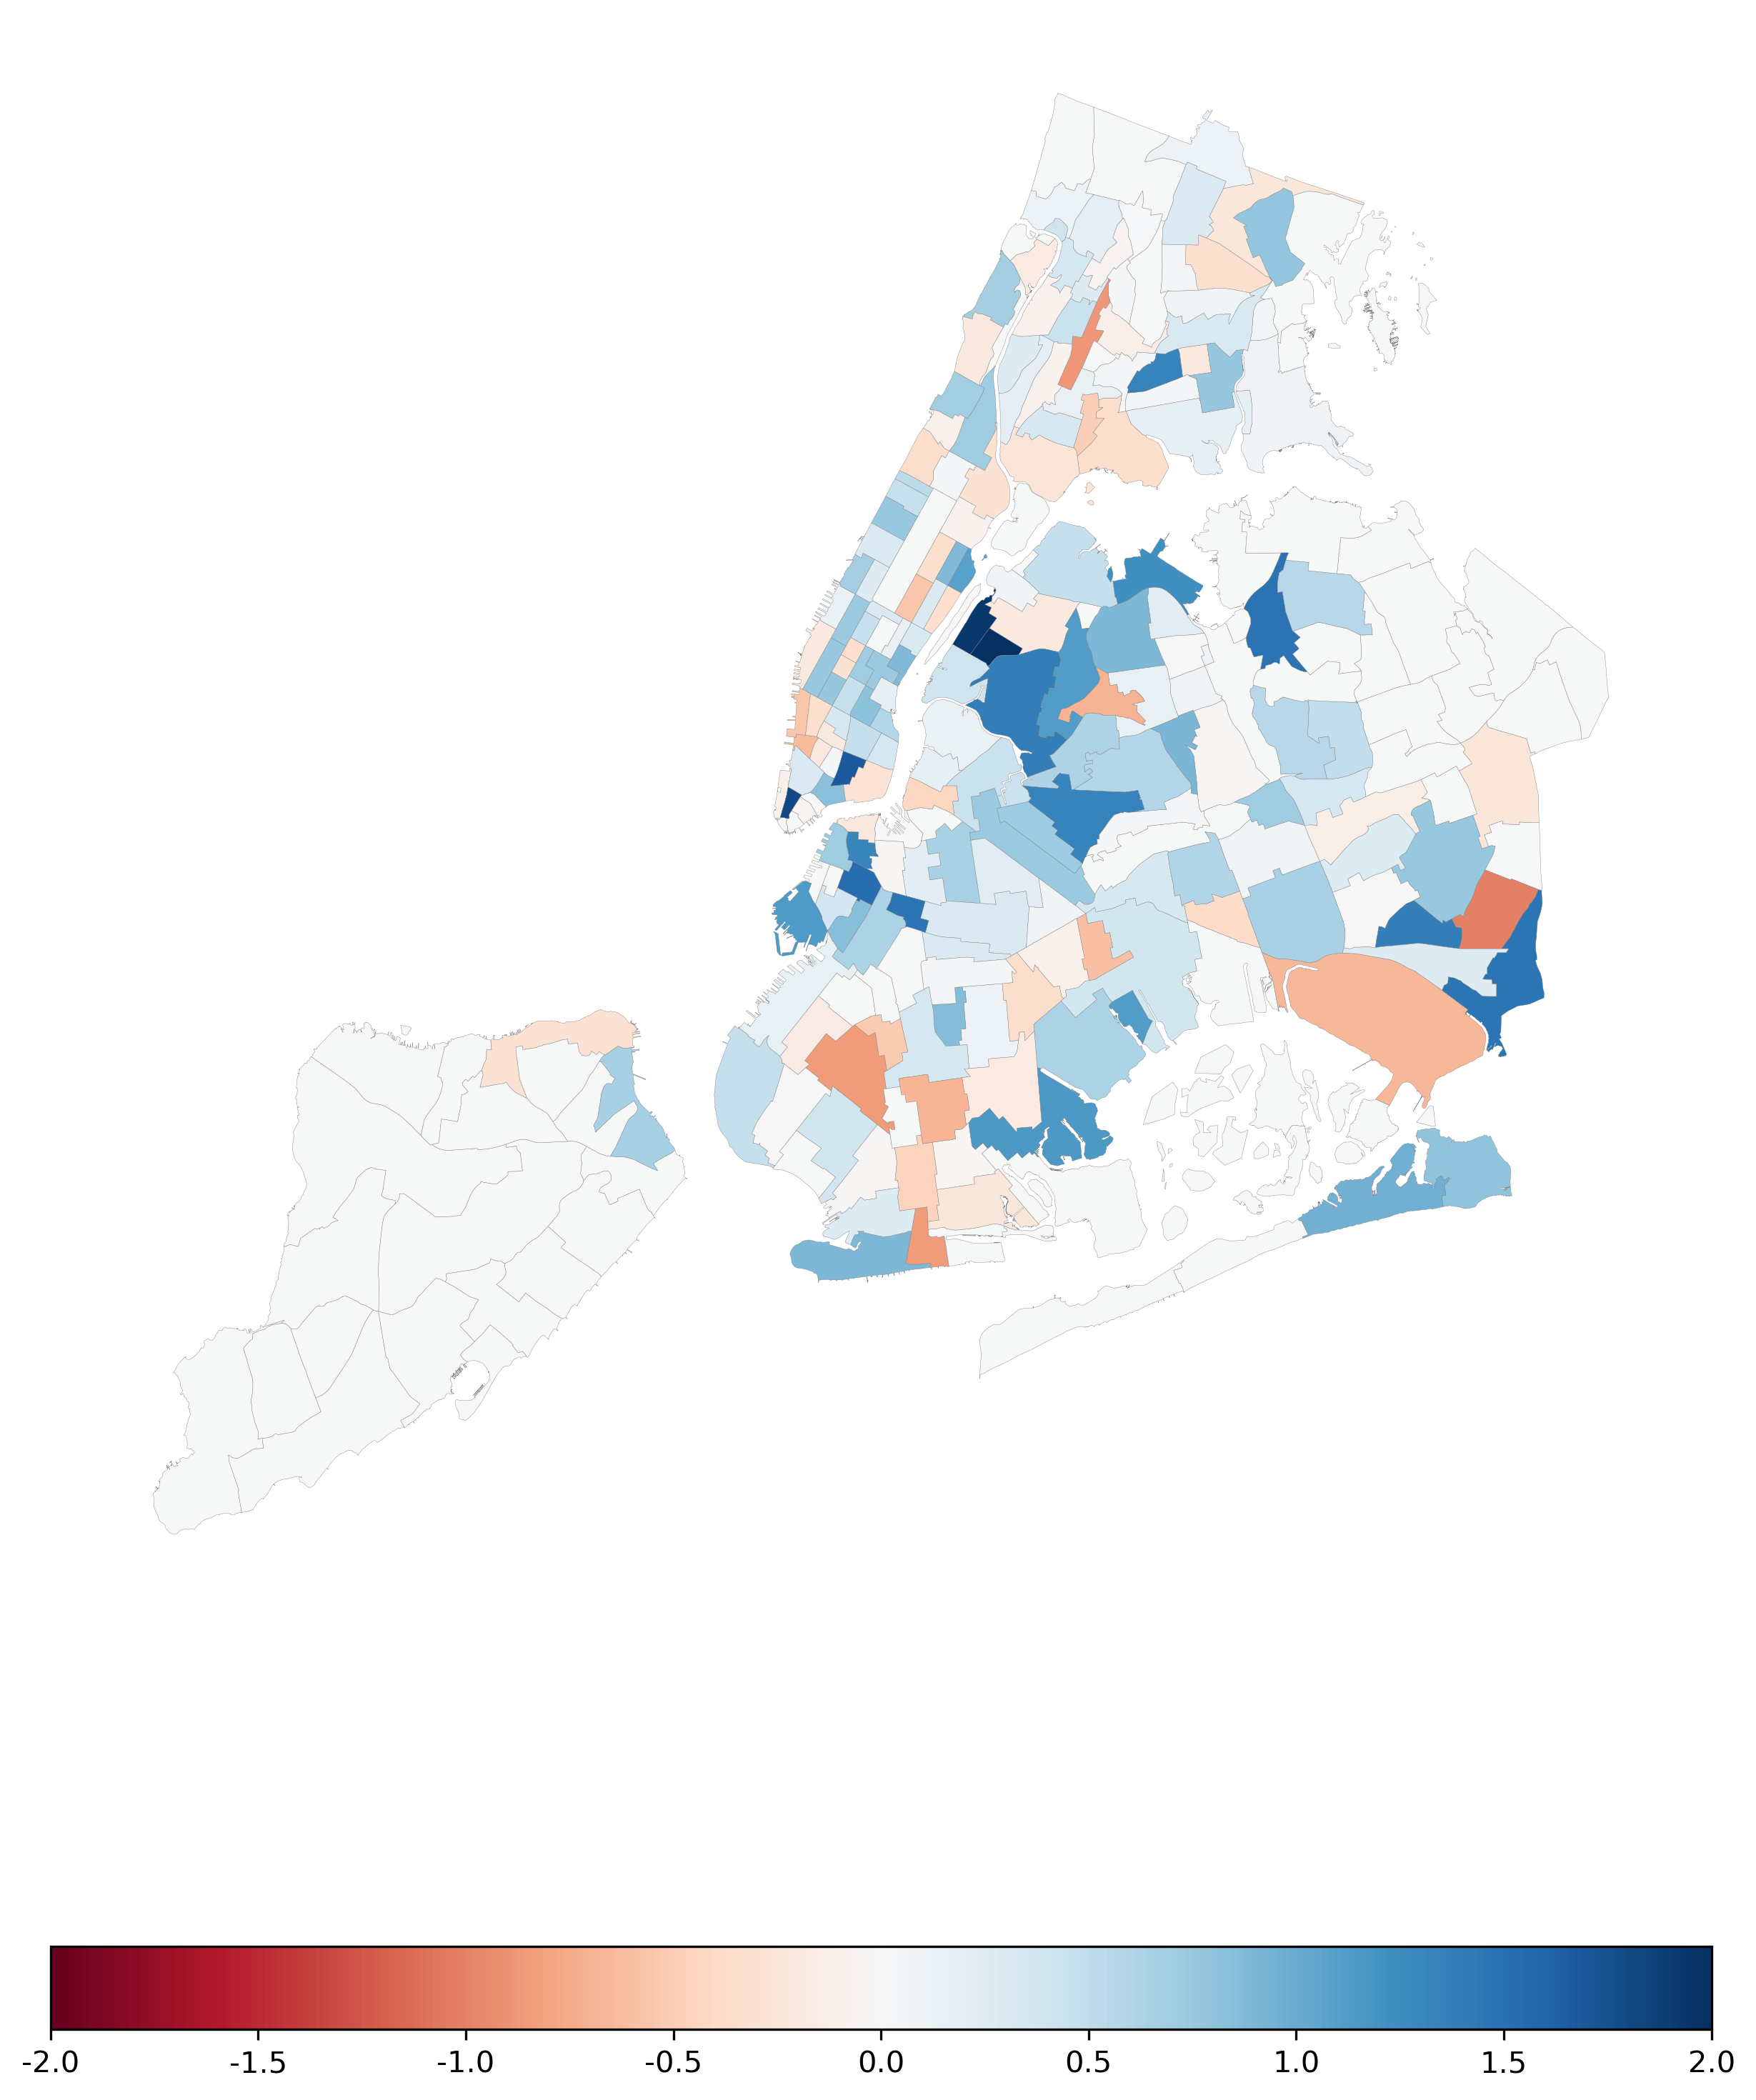

In [347]:
# visualize the change
fig = plt.figure(dpi=300,figsize=(10,14))
now.plot('zscore', ax = plt.gca(), cmap='RdBu', vmin=-2, vmax=2, linewidth=0.1, edgecolor='grey',
         legend=True, legend_kwds={'format': '%.1f', 'orientation': 'horizontal'})
plt.axis(False)

From the above map one can see increased demands in blue areas and decreased demands in red areas. 